In [ ]:
# goal of notebook is to load in subset analysis UNet and MedSAM models
# and then apply them to slices of the MRI 162935
# and then visualize the segmentations. We will visually compare these to the computed segmentaitons from 12-30-24.
# and hopefully they will match

# overall steps:

# 1. import libraries
# 2. load in models
# 3. load in path dataframes, subset to the desired MRI
# 4. Create dataset objects
# 5. Create dataloader objects
# 6. Iterate through dataloader objects, apply models, and visualize segmentations


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from glob import glob
import pandas as pd
import pickle
from torch.utils.data import RandomSampler
import random
import scipy
import torch.nn.functional as F
from PIL import Image
from glob import glob
import wandb
import re
from adjustText import adjust_text
import seaborn as sns
import scipy
import statannot
import argparse
import sys
#print(glob('../../*'))x
sys.path.append('../../modified_medsam_repo')
from MedSAM_HCP.utils_hcp import *
from MedSAM_HCP.dataset import *
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
from MedSAM_HCP.MedSAM import convert_logits_to_preds_onehot

/gpfs/home/kn2347/.conda/envs/medsam/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [99]:
# 2. load in models
# load in the UNet model from subset analysis from 12-30-24
unet_model_path = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/subset_analysis_11-12-24/UNet/training/0.0005/1/1/0/singletask_unet-label1_lr0.0005_subset_1_repeat0-20241118-155514-best_model.pth'
#unet_model_path = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/subset_analysis_11-12-24/UNet/training/0.0005/1/1/1/singletask_unet-label1_lr0.0005_subset_1_repeat1-20241122-033142-best_model.pth'
unet_model = torch.load(unet_model_path)

# load in the MedSAM model from subset analysis from 12-30-24
#medsam_model_path = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/subset_expt_gif_visualizations_12-30-24/segmentations/singletask_medsam/1/1/162935/singletask_seg_all.npy'



In [95]:
label = 1
path = '/gpfs/data/luilab/karthik/pediatric_seg_proj/path_df_unet.csv'

df_hcp = pd.read_csv('/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/hcp_mapping_processed.csv')
df_desired = pd.read_csv('/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/darts_name_class_mapping_processed.csv')
label_converter = LabelConverter(df_hcp, df_desired)
num_classes=1

preprocess_input = get_preprocessing_fn('resnet18', pretrained='imagenet')


train, val, test = load_datasets(
            path,
            '/gpfs/data/luilab/karthik/pediatric_seg_proj/train_val_test_split.pickle',
            label_id = label, bbox_shift=0, 
                sample_n_slices = None, label_converter=label_converter, NUM_CLASSES=num_classes+1, 
                as_one_hot=True, pool_labels=False, preprocess_fn = preprocess_input,
                dataset_type=MRIDataset_Imgs)

test_loader = DataLoader(test, batch_size=1, shuffle=False, num_workers=1)

In [92]:
np.where(test.data_frame['id'] == 162935)
print(8704 + 140)

8844


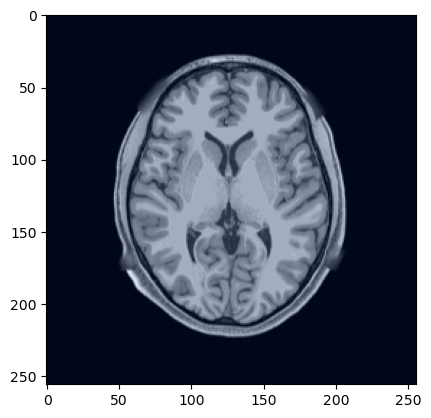

In [93]:

xx = np.transpose(test[8844][0], (1,2,0))
xx = (xx - xx.min())/(xx.max() - xx.min())
xx = np.rot90(xx)
plt.imshow(xx)

In [96]:
for step, (image, gt2D) in enumerate(tqdm(test_loader)):

    if step != 8844:
        continue
    #fac=0
    #boxes[0,0] += fac
    #boxes[0,2] += fac
    image = image.to('cuda')
    gt2D = gt2D.to('cuda') # B x C x H x W
    #z = sam_model(image, boxes)
    #z = sam_model(image, multimask_output=False)

    #z = medsam_model(image, boxes) 
    #z = convert_logits_to_preds_onehot(z, True, H=256, W=256)
    #z = torch.as_tensor(z, dtype=float)
    
    # apply model
    ze = torch.as_tensor(
            unet_model(image), dtype=float
        ).cuda()
    
    
    break

 31%|███       | 8844/28416 [04:54<10:52, 30.00it/s]


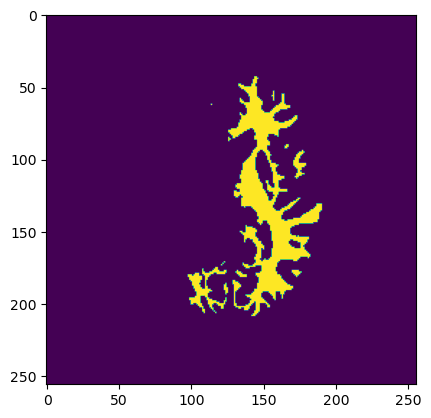

In [100]:
yy = torch.as_tensor(
            unet_model(image), dtype=float
        ).cuda()
yy = (yy > 0.5)[0,0,:,:].cpu().numpy()
yy = np.rot90(yy)
plt.imshow(yy)

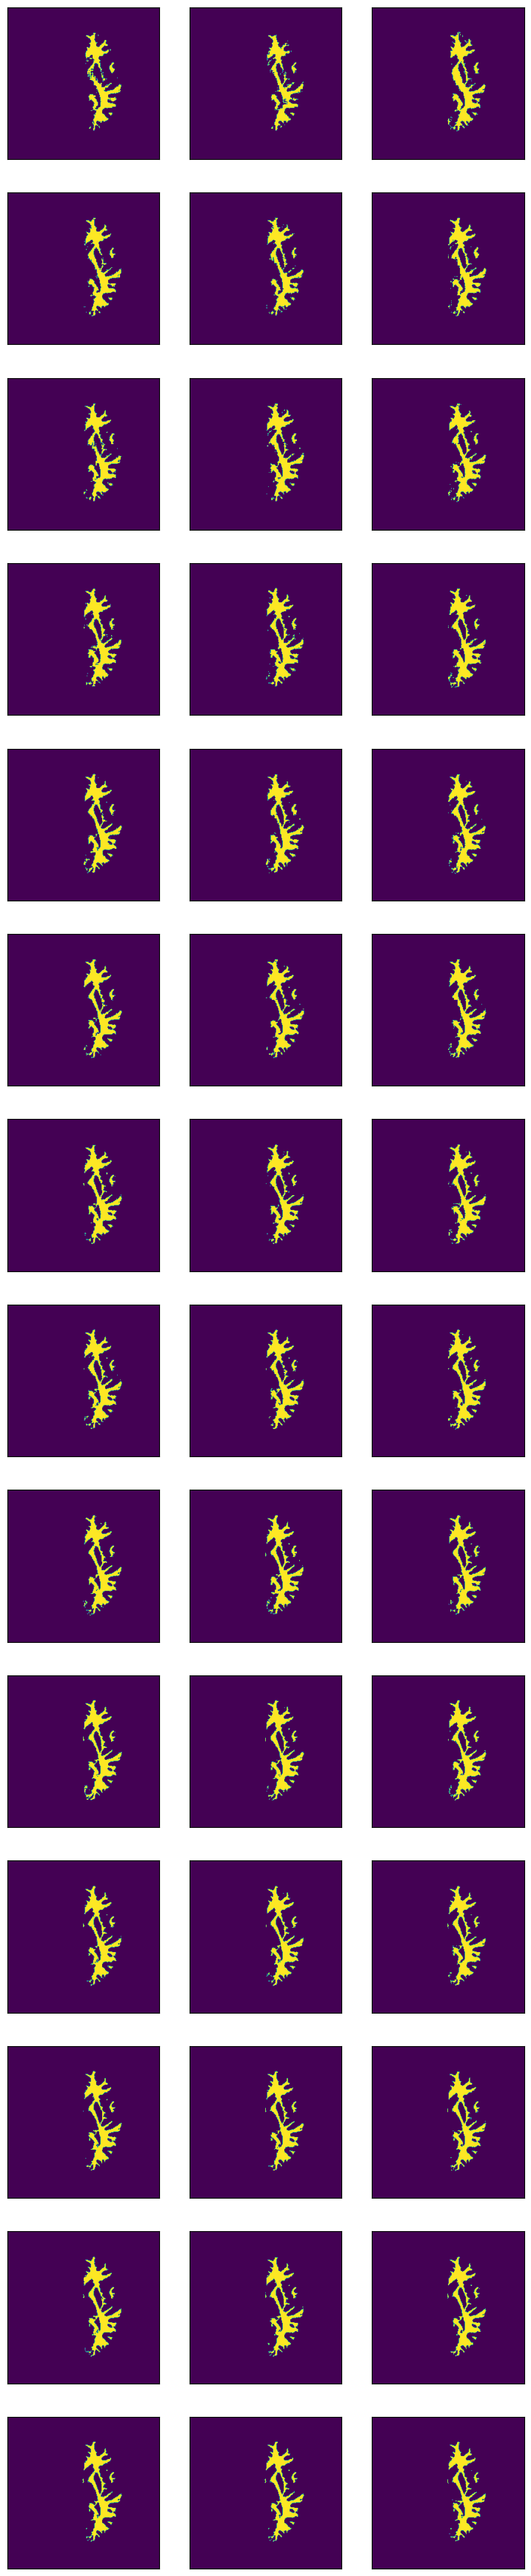

In [115]:


fig, axs = plt.subplots(14, 3, figsize=(3*3,15*3))

for i, subset_size in enumerate([1,2,3,4,5,7,10,15,20,50,100,250,500,891]):
    for repeat in range(3):
        #seg_loaded = np.load(f'/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/subset_expt_gif_visualizations_12-30-24/segmentations/singletask_unet/1/{subset_size}/{repeat}/162935/singletask_seg_all.npy')
        seg_loaded = np.load(f'/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/subset_expt_gif_visualizations_12-30-24/segmentations/singletask_unprompted/1/{subset_size}/{repeat}/162935/singletask_seg_all.npy')
        axs[i, repeat].imshow(np.rot90(seg_loaded[140,:,:]))

        # turn off grid
        axs[i,repeat].grid(False)
        axs[i,repeat].set_xticks([])
        axs[i,repeat].set_yticks([])